In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        input_dim = latent_dim + num_classes  # шум + условие (one-hot)
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, img_dim),
            nn.Tanh()  # изображения в диапазоне [-1, 1]
        )

    def forward(self, noise, labels):
        # Конкатенация шума и one-hot вектора метки
        gen_input = torch.cat((noise, labels), dim=1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *self.img_shape)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_shape):
        super(Discriminator, self).__init__()
        self.img_shape = img_shape
        input_dim = num_classes + img_dim  # изображение (вектор) + условие
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # вероятность "реальности"
        )

    def forward(self, img, labels):
        # Выпрямляем изображение и конкатенируем с условием
        img_flat = img.view(img.size(0), -1)
        d_in = torch.cat((img_flat, labels), dim=1)
        validity = self.model(d_in)
        return validity

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
batch_size = 128
epochs = 50
lr = 0.0002
latent_dim = 100
num_classes = 10
img_shape = (1, 28, 28)
img_dim = int(np.prod(img_shape))

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 458kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.96MB/s]


In [ ]:
def create_one_hot(labels, num_classes):
    return torch.eye(num_classes)[labels].to(device)

In [ ]:
generator = Generator(latent_dim, num_classes, img_shape).to(device)
discriminator = Discriminator(num_classes, img_shape).to(device)

In [ ]:
adversarial_loss = nn.BCELoss()

In [ ]:
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
g_losses = []
d_losses = []

for epoch in range(1, epochs + 1):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    batch_count = 0

    for i, (imgs, labels) in enumerate(dataloader):
        batch_size_i = imgs.size(0)
        batch_count += 1

        # Метки для реальных и сгенерированных примеров
        valid = torch.ones(batch_size_i, 1, device=device)
        fake = torch.zeros(batch_size_i, 1, device=device)

        # Настоящие изображения и их условия
        real_imgs = imgs.to(device)
        labels = labels
        one_hot_labels = create_one_hot(labels, num_classes)

        # ---------------
        # Обучение Генератора
        # ---------------
        optimizer_G.zero_grad()

        # Сэмплируем шум и случайные метки для генерации
        z = torch.randn(batch_size_i, latent_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size_i,))
        gen_one_hot = create_one_hot(gen_labels, num_classes)

        gen_imgs = generator(z, gen_one_hot)
        # Цель генератора – обмануть дискриминатор (целевые метки - valid)
        validity = discriminator(gen_imgs, gen_one_hot)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------
        # Обучение Дискриминатора
        # ---------------
        optimizer_D.zero_grad()

        # Потеря на реальных изображениях
        validity_real = discriminator(real_imgs, one_hot_labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Потеря на сгенерированных изображениях
        validity_fake = discriminator(gen_imgs.detach(), gen_one_hot)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    avg_g_loss = epoch_g_loss / batch_count
    avg_d_loss = epoch_d_loss / batch_count
    g_losses.append(avg_g_loss)
    d_losses.append(avg_d_loss)
    print(f"====> Epoch {epoch}: Average G loss: {avg_g_loss:.4f}, Average D loss: {avg_d_loss:.4f}")

[Epoch 1/50] [Batch 0/469] [D loss: 0.6914] [G loss: 0.6767]
[Epoch 1/50] [Batch 100/469] [D loss: 0.6811] [G loss: 0.5785]
[Epoch 1/50] [Batch 200/469] [D loss: 0.5633] [G loss: 0.6899]
[Epoch 1/50] [Batch 300/469] [D loss: 0.4140] [G loss: 0.8450]
[Epoch 1/50] [Batch 400/469] [D loss: 0.4698] [G loss: 1.1072]
====> Epoch 1: Average G loss: 0.8036, Average D loss: 0.5393
[Epoch 2/50] [Batch 0/469] [D loss: 0.6266] [G loss: 0.5983]
[Epoch 2/50] [Batch 100/469] [D loss: 0.5719] [G loss: 1.1348]
[Epoch 2/50] [Batch 200/469] [D loss: 0.4319] [G loss: 1.0328]
[Epoch 2/50] [Batch 300/469] [D loss: 0.3794] [G loss: 0.7387]
[Epoch 2/50] [Batch 400/469] [D loss: 0.2254] [G loss: 1.4643]
====> Epoch 2: Average G loss: 1.2681, Average D loss: 0.4093
[Epoch 3/50] [Batch 0/469] [D loss: 0.2224] [G loss: 1.5758]
[Epoch 3/50] [Batch 100/469] [D loss: 0.1944] [G loss: 2.0446]
[Epoch 3/50] [Batch 200/469] [D loss: 0.0993] [G loss: 2.0239]
[Epoch 3/50] [Batch 300/469] [D loss: 0.1475] [G loss: 1.7116]


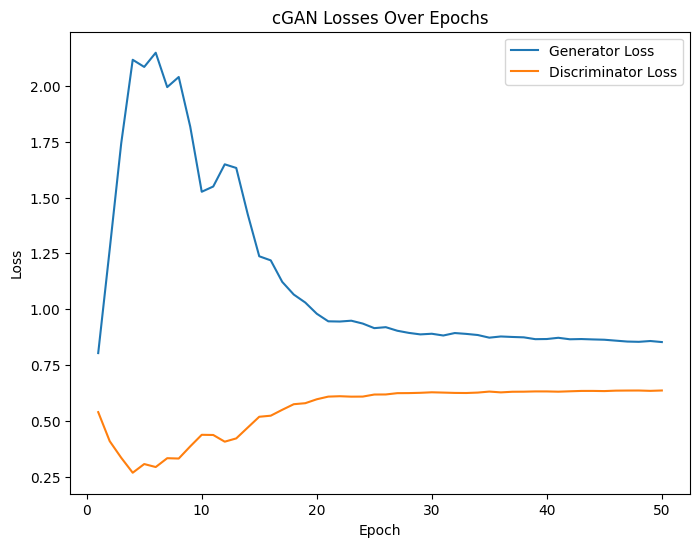

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), g_losses, label="Generator Loss")
plt.plot(range(1, epochs + 1), d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("cGAN Losses Over Epochs")
plt.legend()
plt.show()

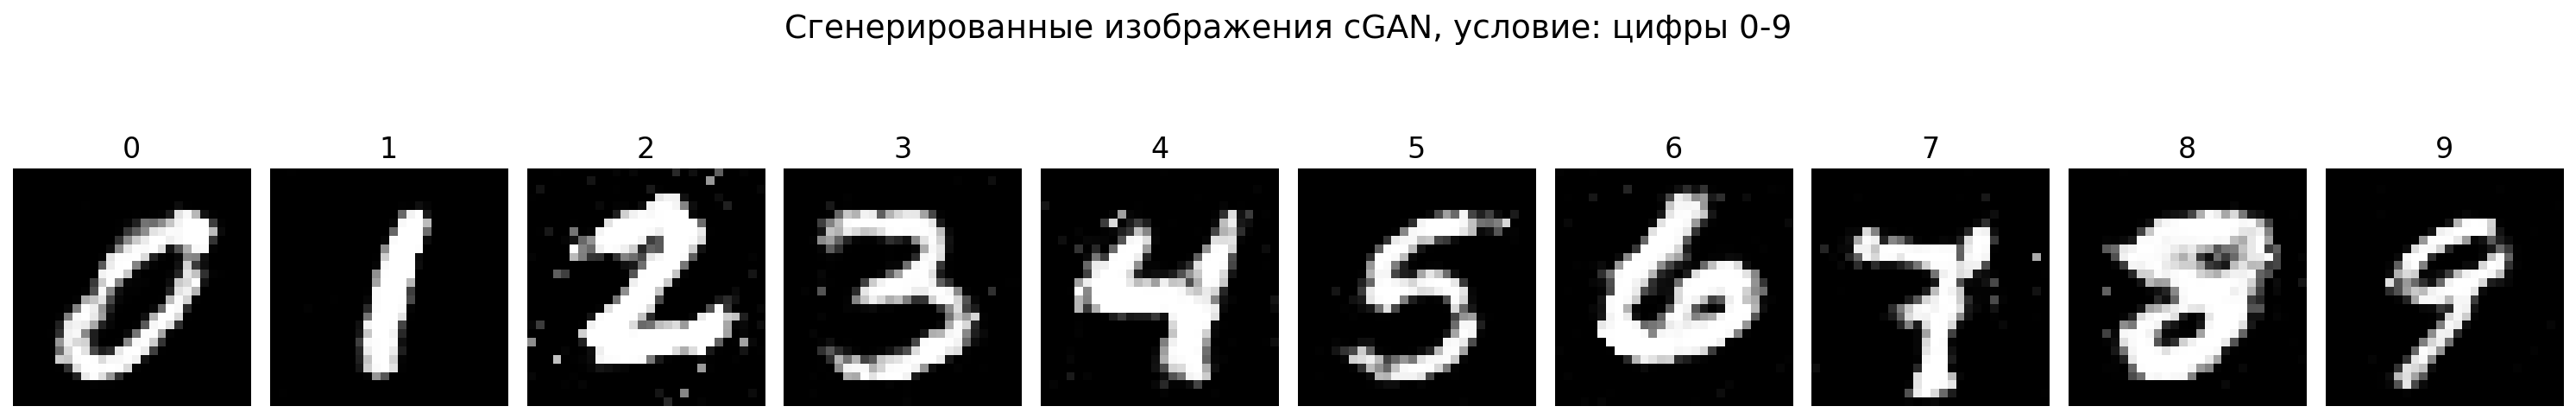

In [ ]:
generator.eval()

n_row = 10
z = torch.randn(n_row, latent_dim, device=device)
labels = torch.arange(0, n_row, dtype=torch.long)
one_hot = create_one_hot(labels, num_classes)
gen_imgs = generator(z, one_hot)
gen_imgs = gen_imgs.detach().cpu()
# Перевод изображений из диапазона [-1,1] в [0,1]
gen_imgs = (gen_imgs + 1) / 2

# Увеличиваем размер фигуры: здесь размер задаётся как (ширина, высота)
fig, axs = plt.subplots(1, n_row, figsize=(20, 4), dpi=150)
for i in range(n_row):
    axs[i].imshow(gen_imgs[i].squeeze(), cmap='gray')
    axs[i].set_title(f"{i}", fontsize=16)
    axs[i].axis('off')
plt.suptitle("Сгенерированные изображения cGAN, условие: цифры 0-9", fontsize=18)
plt.tight_layout()
plt.show()